<a href="https://colab.research.google.com/github/Tee-Sarun/DADS-7202-Deep-Learning/blob/main/CNN1_ex3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare the environment

In [ ]:
# List all NVIDIA GPUs as available in this computer (or Colab's session)
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-537de515-fac7-0afb-4d9a-5e3df1c8161e)


In [ ]:
!pip install torchinfo torchview

In [ ]:
import torchinfo
print( f"torchinfo {torchinfo.__version__}\n" )
import torchview
print( f"torchview {torchview.__version__}\n" )

torchinfo 1.8.0

torchview 0.2.7



In [ ]:
import sys
print( f"Python {sys.version}\n" )

import random
import time

import numpy as np
print( f"NumPy {np.__version__}\n" )

import matplotlib.pyplot as plt
%matplotlib inline

import torch
print( f"PyTorch {torch.__version__}" )

# Get all available accelerators such as CUDA, MPS, MTIA, or XPU
num_accelerators = torch.accelerator.device_count()

if (num_accelerators <= 0):
    print("|- No hardware accelerators found. Using CPU only.")
else:
    print(f"|- PyTorch detected {num_accelerators} hardware accelerator(s)")
    print(f"|- PyTorch detected '{torch.accelerator.current_accelerator().type.upper()}' as the current accelerator")

    # Check cuda availability
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"|- PyTorch detected {num_gpus} CUDA GPU(s):")
    for i in range(num_gpus):
        print(f"   |- CUDA GPU {i}: {torch.cuda.get_device_name(i)}")

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]

NumPy 2.0.2

PyTorch 2.9.0+cu128
|- PyTorch detected 1 hardware accelerator(s)
|- PyTorch detected 'CUDA' as the current accelerator
|- PyTorch detected 1 CUDA GPU(s):
   |- CUDA GPU 0: Tesla T4


In [ ]:
# Reproducibility & Device Configuration
def set_seeds(seed=42):
    """Sets fixed seeds for reproducibility across all libraries."""
    random.seed(seed)     # Controls Python's built-in random numbers.
    np.random.seed(seed)  # Controls NumPy's random arrays.
    torch.manual_seed(seed)           # Controls CPU weight initialization.
    torch.cuda.manual_seed_all(seed)  # Controls GPU weight initialization.

    # Ensure deterministic behavior for some PyTorch operations
    torch.backends.cudnn.deterministic = True # Ensure the GPU doesn't use "fast but slightly random" algorithms for math
    torch.backends.cudnn.benchmark = False
    print(f"Seeds set to {seed} for reproducibility.")

set_seeds(42)

Seeds set to 42 for reproducibility.


In [ ]:
# Detect GPU (CUDA), Apple Silicon (MPS), or fallback to CPU
# 'device' is a scalar flag, not a tensor
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# 2. Create a non-sequential CNN model

In [ ]:
class MyNonSequentialCNN(torch.nn.Module):
    def __init__(self, input_dim1ch, input_dim3ch, output_dimRegress, output_dimCls):
        # Call the parent's constructor method
        super().__init__()

        # --- Input path 1: 1-channel image ---
        self.features_1ch = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=input_dim1ch[0], out_channels=32, kernel_size=3, padding=0),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.BatchNorm2d(num_features=32),

                torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=0),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.BatchNorm2d(num_features=32),

                torch.nn.Flatten()
        )

        # --- Input path 2: 3-channel image ---
        self.features_3ch = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels=input_dim3ch[0], out_channels=32, kernel_size=3, padding=0),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.BatchNorm2d(num_features=32),

                torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=0),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2),
                torch.nn.BatchNorm2d(num_features=32),

                torch.nn.Flatten()
        )

        # --- Automatic Feature Size Calculation ---
        feature_size1d = self._get_feature_size(self.features_1ch, input_dim1ch)
        feature_size3d = self._get_feature_size(self.features_3ch, input_dim3ch)

        # --- Output path 1: regression head ---
        self.output_regress = torch.nn.Sequential(
                torch.nn.Linear(feature_size1d, 512),
                torch.nn.ReLU(),
                torch.nn.Linear(512, output_dimRegress)
        )

        # --- Output path 2: classifier head ---
        self.output_cls = torch.nn.Sequential(
                torch.nn.Linear(feature_size1d + feature_size3d, 1024),
                torch.nn.ReLU(),
                torch.nn.Linear(1024, 1024),
                torch.nn.ReLU(),
                torch.nn.Linear(1024, output_dimCls)
        )

    def _get_feature_size(self, subnetwork, input_dim):
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_dim)
            dummy_output = subnetwork(dummy_input)

            # Total elements = channels * height * width of the final feature map
            return dummy_output.numel()

    def forward(self, x_1ch, x_3ch):
        x_1ch = self.features_1ch(x_1ch)
        x_3ch = self.features_3ch(x_3ch)
        x_concat = torch.cat((x_1ch, x_3ch), dim=-1)

        y_regress = self.output_regress(x_1ch)
        y_cls = self.output_cls(x_concat)
        return y_regress, y_cls

In [ ]:
model = MyNonSequentialCNN((1,224,224), (3,224,224), 4, 20).to(device)
model

MyNonSequentialCNN(
  (features_1ch): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (features_3ch): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, di

Inspect the model:

In [ ]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
MyNonSequentialCNN                       --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─BatchNorm2d: 2-4                  64
│    └─Conv2d: 2-5                       9,248
│    └─ReLU: 2-6                         --
│    └─MaxPool2d: 2-7                    --
│    └─BatchNorm2d: 2-8                  64
│    └─Flatten: 2-9                      --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-10                      896
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
│    └─BatchNorm2d: 2-13                 64
│    └─Conv2d: 2-14                      9,248
│    └─ReLU: 2-15                        --
│    └─MaxPool2d: 2-16                   --
│    └─BatchNorm2d: 2-17                 64
│    └─Flatten: 2-18                     --
├─Sequential: 1-3  

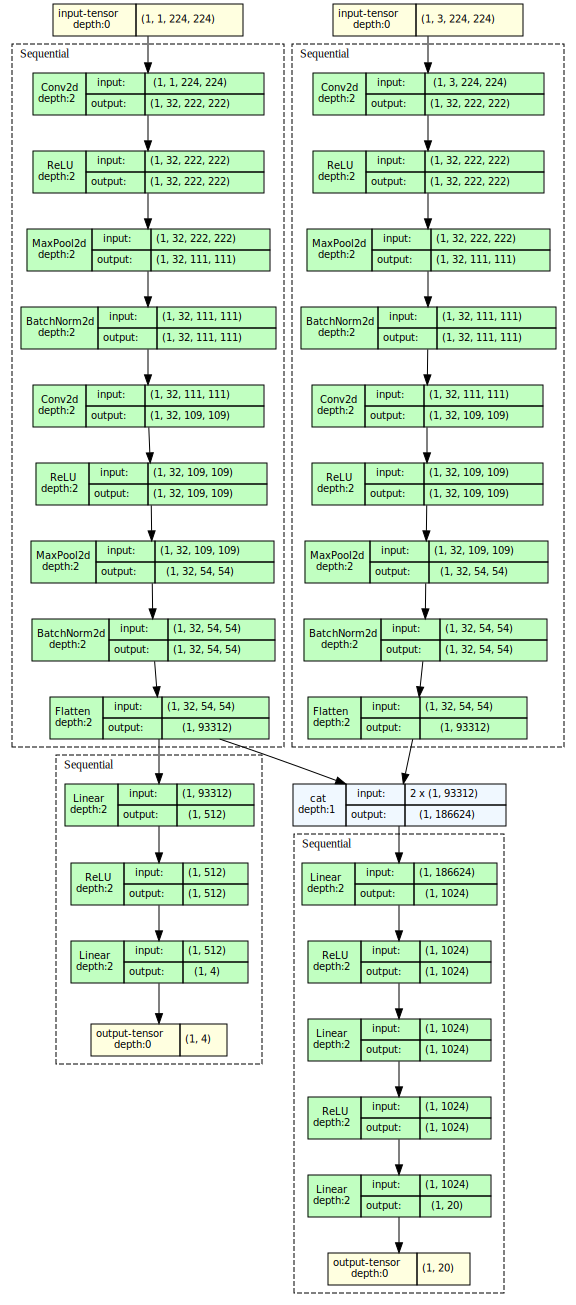

In [ ]:
model_graph = torchview.draw_graph(
    model=model,

    # Pass a list of tuples representing (Batch, Channels, H, W)
    input_size=[(1, 1, 224, 224), (1, 3, 224, 224)],
    expand_nested=True
)

# Save the graph to an image file
model_graph.visual_graph.render("CNN1_ex3", format="png")

# Show the graph in the output cell
model_graph.visual_graph

# 3. Test using the model (with random inputs)

In [ ]:
batch_size = 7

# Create one batch of random input data
# The * unpacking works the same for tuples in torch.rand
x1 = torch.rand(batch_size, 1, 224, 224).to(torch.float32).to(device)
x2 = torch.rand(batch_size, 3, 224, 224).to(torch.float32).to(device)

print(f"{x1.shape = }, {x1.dtype = }, {x1.min() = :.4f}, {x1.max() = :.4f}")
print(f"{x2.shape = }, {x2.dtype = }, {x2.min() = :.4f}, {x2.max() = :.4f}")

x1.shape = torch.Size([7, 1, 224, 224]), x1.dtype = torch.float32, x1.min() = 0.0000, x1.max() = 1.0000
x2.shape = torch.Size([7, 3, 224, 224]), x2.dtype = torch.float32, x2.min() = 0.0000, x2.max() = 1.0000


In [ ]:
y_reg, y_cls = model( x1, x2 )

print(f"{y_reg.shape = }, {y_reg.dtype = }, {y_reg.min() = :.4f}, {y_reg.max() = :.4f}")
print(f"{y_cls.shape = }, {y_cls.dtype = }, {y_cls.min() = :.4f}, {y_cls.max() = :.4f}")

y_reg.shape = torch.Size([7, 4]), y_reg.dtype = torch.float32, y_reg.min() = -0.4643, y_reg.max() = 0.2977
y_cls.shape = torch.Size([7, 20]), y_cls.dtype = torch.float32, y_cls.min() = -0.2795, y_cls.max() = 0.1681
